# Setup

In [1]:
"""
Add parent directorys to current path
"""
import os.path
import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.insert(0,p)
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.insert(0,p)
    
"""
Add tiger-env directory to current path
Still not sure why this is needed.
"""
p = os.path.abspath('../../../custom_envs/gym-tiger')
if p not in sys.path:
    sys.path.insert(0, p)
    

"""
Enable hot-reloading
"""    
from notebook_utils import import_module_by_name, reload_module_by_name

def reload():
    reload_module_by_name('rlpomdp.models.tiger_env', 'QLearner')
    global QLearner
    from rlpomdp.models.tiger_env import QLearner

# Setup ENV and Model

In [18]:
import gym
import gym_tiger
import matplotlib.pyplot as plt
from rlpomdp.utils import play_one, plot_running_avg
from rlpomdp.models.tiger_env import QLearner

env = gym.make('Tiger-v0')
env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
model = QLearner(env, alpha=.001, gamma=1)
eps = 1
n = 0
ot = env.reset()

# Take one action and update Q

$$
Q(s_{t-1}, a_{t-1}) = Q(s_{t-1}, a_{t-1}) + \alpha \big[ r_t + \gamma \cdot Q(s_t, a_t) - Q(s_{t-1}, a_{t-1}) \big]
$$

In [8]:
def print_model(model, n=''):
    print('\n')
    print('{: >10} \tOPEN LEFT | OPEN RIGHT | LISTEN'.format(n))
    print('\t\t--------- | ---------- | ------')
    print("GROWL LEFT {: >14} | {: >10} | {: >6}".format(*model.Q[0].round(2)))
    print("GROWL RIGHT: {: >12} | {: >10} | {: >6}".format(*model.Q[1].round(2)))
    print("START: {: >18} | {: >10} | {: >6}".format(*model.Q[2].round(2)))
    print("END: {: >20} | {: >10} | {: >6}".format(*model.Q[3].round(2)))
    print('\n')

print_model(model)
otm1 = ot
atm1 = model.sample_action(otm1, eps)
ot, r, done, info = env.step(atm1)
at = model.best_action(ot)
model.update(otm1, atm1, r, ot, at)
_otm1 = env.translate_obs(otm1)
_atm1 = env.translate_action(atm1)
print(_otm1, ',', _atm1, ',', r)
print_model(model)



           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -0.74 |       0.24 |   0.65
GROWL RIGHT:         0.31 |        0.8 |   0.62
START:               0.74 |       0.04 |   0.57
END:                 0.72 |       0.84 |   0.17


START , OPEN_LEFT , -100


           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -0.74 |       0.24 |   0.65
GROWL RIGHT:         0.31 |        0.8 |   0.62
START:               0.64 |       0.04 |   0.57
END:                 0.72 |       0.84 |   0.17




# Play 1 Episode

In [61]:
play_one(env, model, eps, verbose=True)

o_t-n,...,o_t-1                          | o_t-1       | a_t-1      | r     | o_t         | a_t       
----------------------------------------------------------------------------------------------------
                                         | START       | OPEN_RIGHT | -100  | END         | OPEN_RIGHT


-100

In [62]:
print_model(model)



           	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -0.18 |      -0.36 |  -0.14
GROWL RIGHT:        -0.88 |      -0.59 |   -0.9
START:               0.38 |       -0.7 |  -0.59
END:                -0.92 |       0.06 |  -0.08




# Play 5K Episodes



         0 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT           0.07 |      -0.38 |   -0.5
GROWL RIGHT:        -0.84 |       0.85 |   0.38
START:               0.33 |      -0.03 |   0.32
END:                 0.32 |      -0.96 |   0.54




      5000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -4.35 |       -4.3 |  -4.29
GROWL RIGHT:        -4.15 |      -4.33 |  -4.17
START:              -4.39 |      -4.47 |  -4.37
END:                 0.32 |      -0.96 |   0.54




     10000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -7.83 |      -7.84 |   -7.8
GROWL RIGHT:        -7.72 |      -7.73 |   -7.7
START:              -8.03 |      -8.08 |   -8.0
END:                 0.32 |      -0.96 |   0.54




     15000 	OPEN LEFT | OPEN RIGHT | LISTEN
		--------- | ---------- | ------
GROWL LEFT          -9.25 |      -7.26 |  -8.99
GROWL RIGHT:        -7.26 |      -9.71 |  -9.09
ST

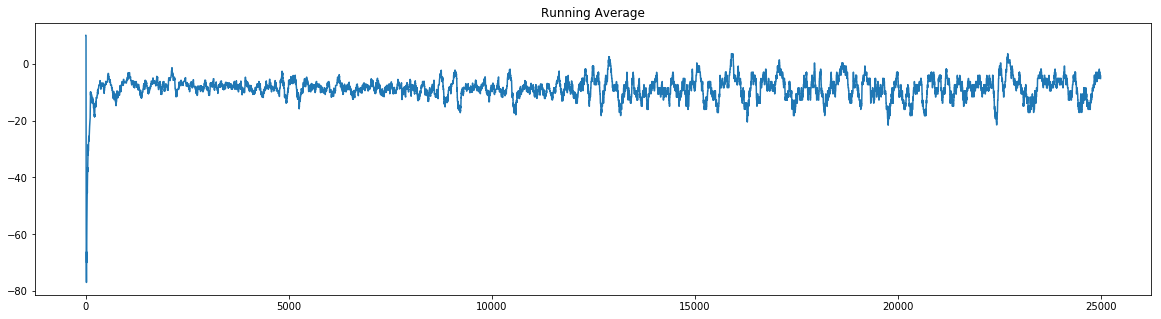

In [19]:
N = 25000
totalrewards = np.empty(N)
for n in range(N):
    if n >= N - 500:
        eps = 0
    else:
        eps = 1.0/np.sqrt(n+1)
        eps=0
    eps = 1.0/np.sqrt(n+1)
    totalreward = play_one(env, model, eps, max_steps=3)
    totalrewards[n] = totalreward
    if n % (N/5) == 0:
        print_model(model, n=n)

print("avg reward for last 500 episodes:", totalrewards[-500:].mean())

print_model(model, n=n)
plot_running_avg(totalrewards)

# Play 5K episodes 25 times and average last 500 mean scores

In [90]:
last500rewards = np.zeros(25)

for epoch in range(25):
    # Reset environment
    env = gym.make('Tiger-v0')
    env.__init__(reward_tiger=-100, reward_gold=10, reward_listen=-1)
    model = QLearner(env, alpha=.01, gamma=1)
    eps = 1
    n = 0
    ot = env.reset()

    # Play episodes
    N = 5000
    totalrewards = np.empty(N)
    for n in range(N):
        # For performance measure, don't want to explore.
        if n >= N - 500:
            eps = 0
        else:
            eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps)
        totalrewards[n] = totalreward
    print("avg reward for last 500 episodes:", totalrewards[-500:].mean())
    last500rewards[epoch] = totalrewards[-500:].mean()
    
print('last500rewards avg: ', last500rewards.mean())

avg reward for last 500 episodes: -9.48
avg reward for last 500 episodes: -9.48
avg reward for last 500 episodes: -8.38
avg reward for last 500 episodes: -11.02
avg reward for last 500 episodes: -9.26
avg reward for last 500 episodes: -6.62
avg reward for last 500 episodes: -6.4
avg reward for last 500 episodes: -7.72
avg reward for last 500 episodes: -7.72
avg reward for last 500 episodes: -6.62
avg reward for last 500 episodes: -6.18
avg reward for last 500 episodes: -9.92
avg reward for last 500 episodes: -8.38
avg reward for last 500 episodes: -6.62
avg reward for last 500 episodes: -6.4
avg reward for last 500 episodes: -12.34
avg reward for last 500 episodes: -10.14
avg reward for last 500 episodes: -7.06
avg reward for last 500 episodes: -6.4
avg reward for last 500 episodes: -7.28
avg reward for last 500 episodes: -8.16
avg reward for last 500 episodes: -9.7
avg reward for last 500 episodes: -7.28
avg reward for last 500 episodes: -6.62
avg reward for last 500 episodes: -8.6
la

# Conclusions